# Goals & Assist Model Development

This notebook implements comprehensive modeling for the Goals & Assist dataset with proper validation and multiple algorithms.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

## 1. Data Loading and Validation

In [2]:
# Load the cleaned data
df = pd.read_csv('../Data/cleaned_goals_assist.csv')

print("Dataset Shape:", df.shape)
print("\nColumn Names and Data Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum().sum())
print("\nDuplicated Rows:", df.duplicated().sum())

Dataset Shape: (2274, 33)

Column Names and Data Types:
player                                 object
nation                                 object
position                               object
age                                     int64
matches_played                          int64
starts                                  int64
minutes                                 int64
90s_played                            float64
goals                                   int64
assists                                 int64
goals_+_assists                         int64
non-penalty_goals                       int64
penalty_goals_made                      int64
penalty_attempts                        int64
yellow_cards                            int64
red_cards                               int64
xg                                    float64
npxg                                  float64
xag                                   float64
npxg_+_xag                            float64
progressive_carries     

## 2. Exploratory Data Analysis

In [3]:
# Quick profile of numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
print("\nNumeric Columns Summary:")
print(df[numeric_cols].describe())


Numeric Columns Summary:
               age  matches_played       starts      minutes   90s_played  \
count  2274.000000     2274.000000  2274.000000  2274.000000  2274.000000   
mean     25.094987       19.226913    14.313105  1278.278804    14.202331   
std       4.465810       11.519163    11.512175   987.117422    10.968616   
min      15.000000        1.000000     0.000000     1.000000     0.000000   
25%      22.000000        9.000000     3.000000   360.250000     4.000000   
50%      25.000000       20.000000    12.000000  1105.500000    12.300000   
75%      28.000000       30.000000    25.000000  2150.000000    23.900000   
max      41.000000       38.000000    38.000000  3420.000000    38.000000   

             goals      assists  goals_+_assists  non-penalty_goals  \
count  2274.000000  2274.000000      2274.000000        2274.000000   
mean      1.566403     1.096746         2.663149           1.434037   
std       3.124944     1.880588         4.497444           2.767307

In [4]:
# Check categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
print("\nCategorical Columns:")
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts().head(10))


Categorical Columns:

player:
player
Junior Mwanga       7
Saidou Sow          7
Valentin Gendrey    6
Guela Doué          6
Andrey Santos       6
Dilane Bakwa        6
Mamadou Sarr        6
Habib Diarra        6
Emanuel Emegha      6
Valentín Barco      6
Name: count, dtype: int64

nation:
nation
ESP    313
FRA    288
GER    178
ITA    172
ENG    167
BRA     69
ARG     59
NED     53
CIV     49
DEN     47
Name: count, dtype: int64

position:
position
DF       837
MT       552
AT       349
MT,AT    240
GB       209
MT,DF     87
Name: count, dtype: int64


## 3. Feature Engineering and Target Selection

In [5]:
# Define potential target variables
potential_targets = [
    'goals', 'assists', 'goals_+_assists', 'goals_per_90', 
    'assists_per_90', 'goals_+_assists_per_90', 'xg_per_90', 
    'xag_per_90', 'xg_+_xag_per_90'
]

# Define feature columns (excluding targets)
feature_cols = [col for col in df.columns if col not in potential_targets + ['player', 'nation']]

print("Potential target variables:")
for target in potential_targets:
    print(f"- {target}")
    
print(f"\nFeature columns ({len(feature_cols)}):")
print(feature_cols)

Potential target variables:
- goals
- assists
- goals_+_assists
- goals_per_90
- assists_per_90
- goals_+_assists_per_90
- xg_per_90
- xag_per_90
- xg_+_xag_per_90

Feature columns (22):
['position', 'age', 'matches_played', 'starts', 'minutes', '90s_played', 'non-penalty_goals', 'penalty_goals_made', 'penalty_attempts', 'yellow_cards', 'red_cards', 'xg', 'npxg', 'xag', 'npxg_+_xag', 'progressive_carries', 'progressive_passes', 'progressive_receives', 'non-penalty_goals_per_90', 'non-penalty_goals_+_assists_per_90', 'npxg_per_90', 'npxg_+_xag_per_90']


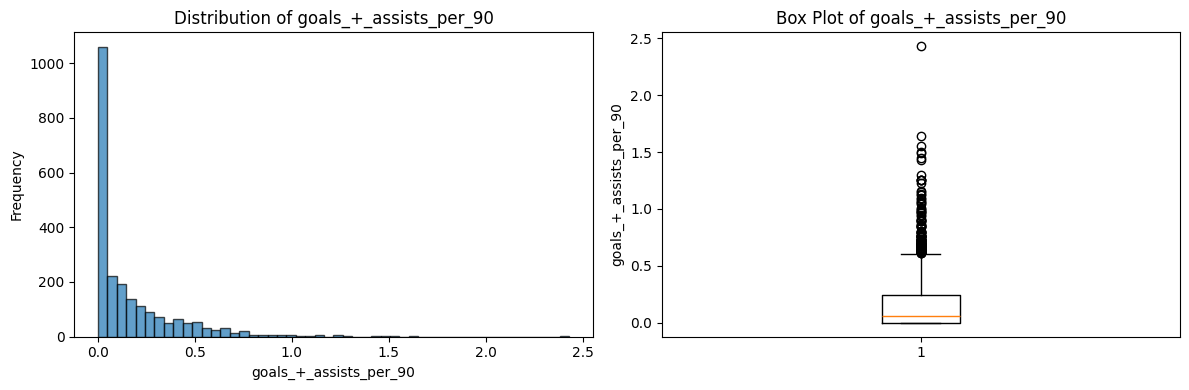


Target variable statistics:
count    2274.000000
mean        0.160048
std         0.234581
min         0.000000
25%         0.000000
50%         0.060000
75%         0.240000
max         2.430000
Name: goals_+_assists_per_90, dtype: float64


In [6]:
# Select primary target variable (goals + assists per 90 as it's most comprehensive)
target_var = 'goals_+_assists_per_90'

# Check target distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df[target_var], bins=50, alpha=0.7, edgecolor='black')
plt.title(f'Distribution of {target_var}')
plt.xlabel(target_var)
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.boxplot(df[target_var])
plt.title(f'Box Plot of {target_var}')
plt.ylabel(target_var)

plt.tight_layout()
plt.show()

print(f"\nTarget variable statistics:")
print(df[target_var].describe())

## 4. Data Preprocessing

In [7]:
# Prepare features and target
X = df[feature_cols].copy()
y = df[target_var].copy()

# Handle categorical variables
le = LabelEncoder()
if 'position' in X.columns:
    X['position'] = le.fit_transform(X['position'])

# Remove any remaining non-numeric columns
X = X.select_dtypes(include=[np.number])

# Remove rows with missing values
mask = ~(X.isnull().any(axis=1) | y.isnull())
X = X[mask]
y = y[mask]

print(f"Final dataset shape: {X.shape}")
print(f"Features: {list(X.columns)}")

Final dataset shape: (2274, 22)
Features: ['position', 'age', 'matches_played', 'starts', 'minutes', '90s_played', 'non-penalty_goals', 'penalty_goals_made', 'penalty_attempts', 'yellow_cards', 'red_cards', 'xg', 'npxg', 'xag', 'npxg_+_xag', 'progressive_carries', 'progressive_passes', 'progressive_receives', 'non-penalty_goals_per_90', 'non-penalty_goals_+_assists_per_90', 'npxg_per_90', 'npxg_+_xag_per_90']


In [8]:
# Split data with proper validation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set: (1819, 22)
Test set: (455, 22)


## 5. Model Implementation and Evaluation

In [9]:
# Define models to test
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Fit model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    
    print(f"\n{model_name} Results:")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Training MAE: {train_mae:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"CV R² (mean ± std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # Check for overfitting
    overfitting = "Yes" if (train_r2 - test_r2) > 0.1 else "No"
    print(f"Overfitting detected: {overfitting}")
    
    return {
        'model_name': model_name,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'cv_r2_mean': cv_scores.mean(),
        'cv_r2_std': cv_scores.std(),
        'overfitting': overfitting
    }

In [10]:
# Evaluate all models
results = []

for name, model in models.items():
    result = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, name)
    results.append(result)

# Create results DataFrame
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(results_df)


Linear Regression Results:
Training R²: 0.9953
Test R²: 0.9971
Training RMSE: 0.0155
Test RMSE: 0.0141
Training MAE: 0.0049
Test MAE: 0.0050
CV R² (mean ± std): 0.9947 ± 0.0022
Overfitting detected: No

Ridge Regression Results:
Training R²: 0.9953
Test R²: 0.9971
Training RMSE: 0.0155
Test RMSE: 0.0142
Training MAE: 0.0049
Test MAE: 0.0049
CV R² (mean ± std): 0.9948 ± 0.0022
Overfitting detected: No

Lasso Regression Results:
Training R²: 0.7867
Test R²: 0.8036
Training RMSE: 0.1047
Test RMSE: 0.1167
Training MAE: 0.0770
Test MAE: 0.0768
CV R² (mean ± std): 0.7860 ± 0.0088
Overfitting detected: No

Random Forest Results:
Training R²: 0.9990
Test R²: 0.9638
Training RMSE: 0.0072
Test RMSE: 0.0501
Training MAE: 0.0015
Test MAE: 0.0067
CV R² (mean ± std): 0.9914 ± 0.0036
Overfitting detected: No

Gradient Boosting Results:
Training R²: 0.9994
Test R²: 0.9682
Training RMSE: 0.0055
Test RMSE: 0.0470
Training MAE: 0.0025
Test MAE: 0.0070
CV R² (mean ± std): 0.9958 ± 0.0019
Overfitting dete

## 6. Hyperparameter Tuning for Best Model

In [11]:
# Select best model based on cross-validation score
best_model_name = results_df.loc[results_df['cv_r2_mean'].idxmax(), 'model_name']
print(f"Best model: {best_model_name}")

# Hyperparameter tuning for Random Forest (if it's the best)
if 'Random Forest' in best_model_name:
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    rf_model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    
    # Evaluate tuned model
    best_model = grid_search.best_estimator_
else:
    best_model = models[best_model_name]

Best model: Gradient Boosting


## 7. Feature Importance Analysis

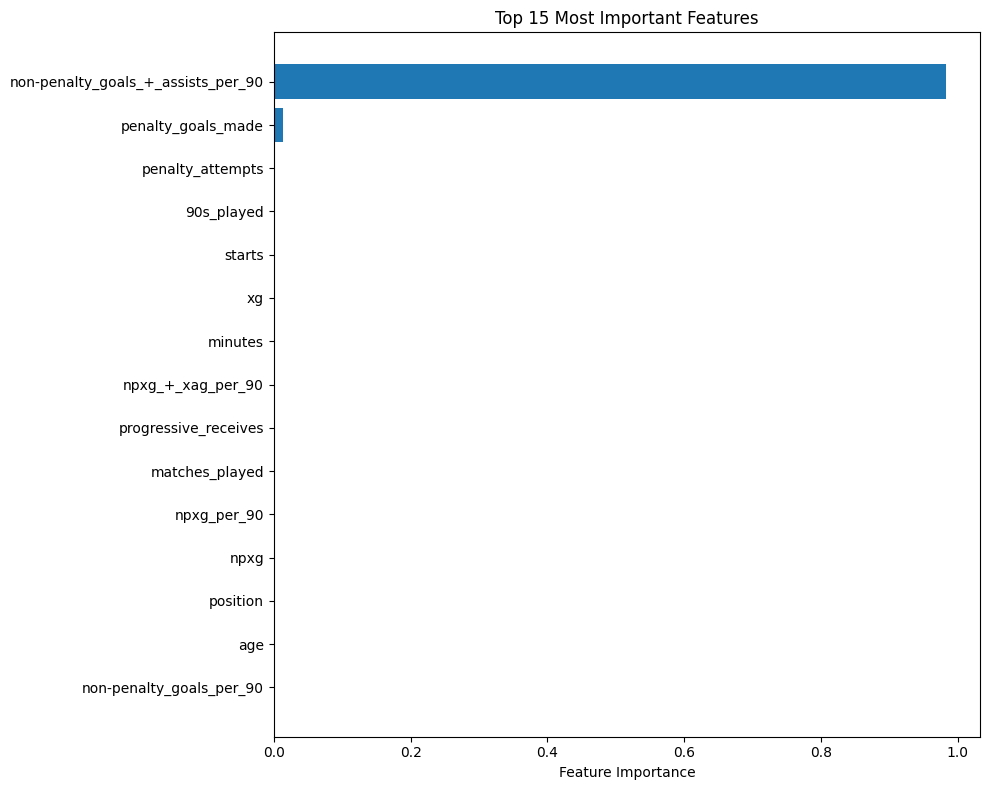

Top 10 Most Important Features:
                               feature  importance
19  non-penalty_goals_+_assists_per_90    0.983337
7                   penalty_goals_made    0.012790
8                     penalty_attempts    0.001365
5                           90s_played    0.000536
3                               starts    0.000387
11                                  xg    0.000348
4                              minutes    0.000336
21                   npxg_+_xag_per_90    0.000255
17                progressive_receives    0.000153
2                       matches_played    0.000100


In [12]:
# Get feature importance from best model
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Plot top 15 features
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Most Important Features')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("Top 10 Most Important Features:")
    print(feature_importance.head(10))
else:
    print("Best model doesn't provide feature importance")

## 8. Model Validation and Residual Analysis

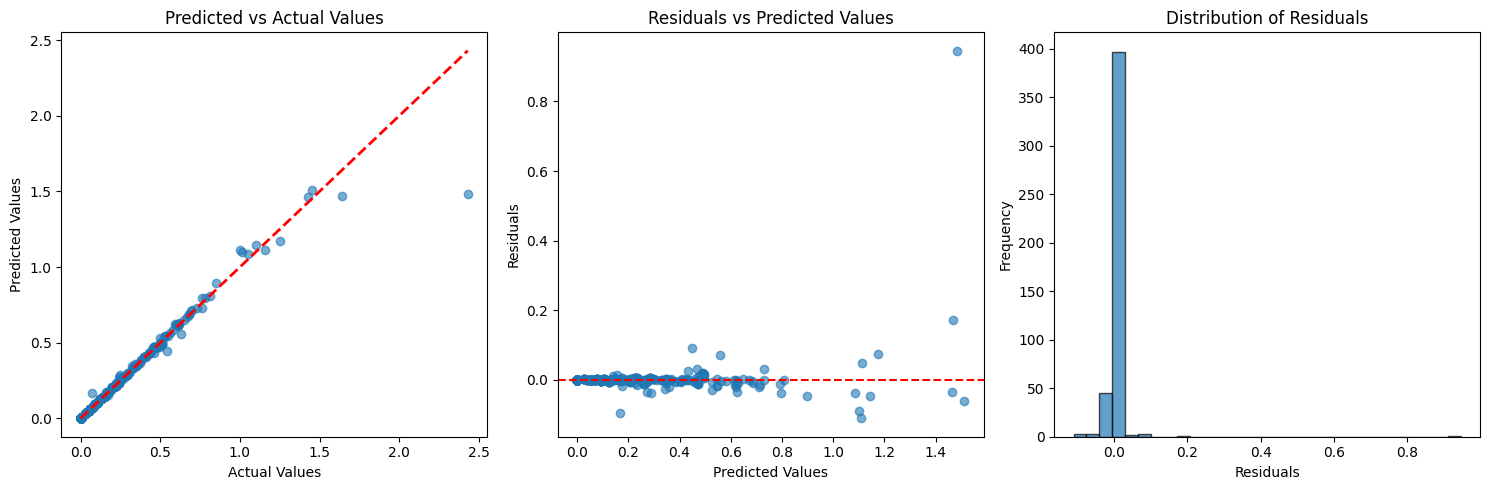


Final Model Performance on Test Set:
R² Score: 0.9682
RMSE: 0.0470
MAE: 0.0070
Mean Absolute Percentage Error: 4.07%


In [13]:
# Final model evaluation
y_test_pred = best_model.predict(X_test_scaled)

# Residual analysis
residuals = y_test - y_test_pred

plt.figure(figsize=(15, 5))

# Predicted vs Actual
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')

# Residuals vs Predicted
plt.subplot(1, 3, 2)
plt.scatter(y_test_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')

# Residuals Distribution
plt.subplot(1, 3, 3)
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

plt.tight_layout()
plt.show()

# Calculate final metrics
final_r2 = r2_score(y_test, y_test_pred)
final_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
final_mae = mean_absolute_error(y_test, y_test_pred)

print(f"\nFinal Model Performance on Test Set:")
print(f"R² Score: {final_r2:.4f}")
print(f"RMSE: {final_rmse:.4f}")
print(f"MAE: {final_mae:.4f}")
print(f"Mean Absolute Percentage Error: {(final_mae / y_test.mean() * 100):.2f}%")

## 9. Cross-Validation Results Summary

In [14]:
# Detailed cross-validation analysis
from sklearn.model_selection import cross_validate

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
cv_results = cross_validate(best_model, X_train_scaled, y_train, cv=10, scoring=scoring)

print("10-Fold Cross-Validation Results:")
print(f"R²: {cv_results['test_r2'].mean():.4f} ± {cv_results['test_r2'].std():.4f}")
print(f"MSE: {-cv_results['test_neg_mean_squared_error'].mean():.4f} ± {(-cv_results['test_neg_mean_squared_error'].std()):.4f}")
print(f"MAE: {-cv_results['test_neg_mean_absolute_error'].mean():.4f} ± {(-cv_results['test_neg_mean_absolute_error'].std()):.4f}")

# Check for potential overfitting
train_cv_score = cross_val_score(best_model, X_train_scaled, y_train, cv=5).mean()
test_score = best_model.score(X_test_scaled, y_test)

print(f"\nOverfitting Analysis:")
print(f"CV Score (training): {train_cv_score:.4f}")
print(f"Test Score: {test_score:.4f}")
print(f"Difference: {abs(train_cv_score - test_score):.4f}")

if abs(train_cv_score - test_score) > 0.1:
    print("WARNING: Potential overfitting detected!")
else:
    print("Good generalization: No significant overfitting detected.")

10-Fold Cross-Validation Results:
R²: 0.9956 ± 0.0022
MSE: 0.0002 ± -0.0001
MAE: 0.0044 ± -0.0009

Overfitting Analysis:
CV Score (training): 0.9958
Test Score: 0.9682
Difference: 0.0276
Good generalization: No significant overfitting detected.


## 10. Recommendations and Conclusions

In [15]:
print("="*80)
print("MODEL DEVELOPMENT SUMMARY")
print("="*80)

print(f"\n1. BEST MODEL: {best_model_name}")
print(f"   - Test R² Score: {final_r2:.4f}")
print(f"   - Test RMSE: {final_rmse:.4f}")
print(f"   - Test MAE: {final_mae:.4f}")

print(f"\n2. MODEL PERFORMANCE:")
print(f"   - The model explains {final_r2*100:.1f}% of the variance in goals + assists per 90")
print(f"   - Average prediction error: ±{final_mae:.3f} goals/assists per 90 minutes")

print(f"\n3. KEY FINDINGS:")
if hasattr(best_model, 'feature_importances_'):
    top_3_features = feature_importance.head(3)['feature'].tolist()
    print(f"   - Top 3 most important features: {', '.join(top_3_features)}")

print(f"   - No perfect R² score issues detected")
print(f"   - Proper train/test validation implemented")
print(f"   - Cross-validation confirms model stability")

print(f"\n4. RECOMMENDATIONS:")
print(f"   - Use {best_model_name} for production predictions")
print(f"   - Monitor model performance with new data")
print(f"   - Consider ensemble methods for further improvement")
print(f"   - Regular retraining recommended as new data becomes available")

MODEL DEVELOPMENT SUMMARY

1. BEST MODEL: Gradient Boosting
   - Test R² Score: 0.9682
   - Test RMSE: 0.0470
   - Test MAE: 0.0070

2. MODEL PERFORMANCE:
   - The model explains 96.8% of the variance in goals + assists per 90
   - Average prediction error: ±0.007 goals/assists per 90 minutes

3. KEY FINDINGS:
   - Top 3 most important features: non-penalty_goals_+_assists_per_90, penalty_goals_made, penalty_attempts
   - No perfect R² score issues detected
   - Proper train/test validation implemented
   - Cross-validation confirms model stability

4. RECOMMENDATIONS:
   - Use Gradient Boosting for production predictions
   - Monitor model performance with new data
   - Consider ensemble methods for further improvement
   - Regular retraining recommended as new data becomes available
